# Create a table that contains the ion densities calculated by CMFGen 
from the POP files.  The routine assumes the POP files are all in a
specific directory

The POP files format is not very well explained in the documentation, and parsing it is not straight forward because the bit os information are not documeented in the documentation.  

In particular, there are a set of lines that come after a line that contains the word Oscilator.  These contain the densities of the level populations of a particular ion as a function of grid cell.  The last n numbers, where n is the number of cells, contains the total densities for that ion.  The organization of the population of the individual levels is not specified in the documentation, and is something ksl has not fully worked out.  It seems not to be that one can simply take the first n elements and assume that this is the ion density of the first level.  Part of the issue is, that the abundances at the end of each section of the file, are one ion state higher than the last ion mentioned in the file, and thus if you use the last ion mentioned, one has to increase the ionization state by one.

The densities that are obtained by this routine go from the outside of the wind to the photosphere.

250314 - This routine gave incorrect answers at the time of the release paper.  This version is intended to correct thos errors, and produce astropy tables that conain the densisties correctly.  I have compared the results to those presented plotted from Hillier's routines, and the results are as far as I can tell identical, except that he has some kind of method for caculating a lower ionization state than is actually in the model, e.g for C, the data that is actually in the file starts with CIII, but in his plots one can also see CII.  I exploured the idea that one could simply add up all the ion densities of the ions that are there and subtract this from the total, but this did not seem to work.  

The files produced by this routine had the postion of the cell stated so one does not have to combine the two files.  


ksl

In [218]:
from glob import glob
from astropy.table import Table,vstack,join
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import os
os.getcwd()

'/media/ssd4/Projects/release-models/Details/cmfgen/cmfgen'

These files produced by HIlliar are not straightforward to interpred, largely because there is not clear way that the ions are identifie, and in particular threre is no place that allows one to determine what the first ionsate is.  The easiest thing to do, may be to create a lookup for each file where we have inspected it

In [219]:
def get_den_for_one_atom(filename='a3/POPHYD',outroot=''):
    z=open(filename)
    lines=z.readlines()
    xabun=False
    xpop=False
    xnum=False
    record_abun=[]
    record_pop=[]
    pop_stack=[]
    nd=0
    nden=[]
    nlev=[]
    xlabel=[]
    i=0
    for line in lines:
        word=line.split()
        try:
            xline=[]
            for one_word in word:
                xline.append(eval(one_word))
            xnum=True
        except:
            xnum=False
        if xnum==True and xabun==True:
            record_abun+=xline
        elif xnum==True and xpop==True:
            record_pop+=xline
        
        
        if word[0]=='ND:':
            nd=int(word[1])
        if word[1]=='abundance:':
            atom=word[0].split('/')[0]
            print(atom)
            xabun=True
            xpop=False
            record_abun=[]
        elif word[0]=='Number':
            nlev.append(int(word[4]))
            xlabel.append(word[2])
        elif word[1]=='Oscillator':
            nden.append(i+1)
            xpop=True
            xabun=False
            if len(record_pop)>0:
                record_pop=np.array(record_pop)
                pop_stack.append(record_pop)
            record_pop=[]
 
            
        
        i+=1

    print('atom',atom)

    if len(record_pop)>0:
        record_pop=np.array(record_pop)
        pop_stack.append(record_pop)
    print('ND ', nd)
    print('nden: ',nden)
    print('nlev: ',nlev)
    print(len(record_abun),len(record_pop),len(pop_stack))

    qnum=range(len(record_abun))
    abun_tab=Table([qnum,record_abun],names=['n',atom])

    abun_tab.info()

    i=0
    for one in pop_stack:
        xden=one[-nd:]
        xtab=Table([qnum,xden],names=['n',xlabel[i]])
        if i==0:
            xfinal=join(abun_tab,xtab,join_type='left')
        else:
            xfinal=join(xfinal,xtab,join_type='left')
        # xfinal.append(one[-nd:])
        i+=1
        

    if outroot=='':
        outroot='test'

    outname='%s.%s.txt' % (outroot,atom)



    xfinal.info()
    # xfinal.write('foo.%s.txt' % atom,format='ascii.fixed_width_two_line',overwrite=True)

    if xfinal.colnames[1]=='HE':
        xfinal.rename_column('He2','HeIII')
        xfinal.rename_column('HeI','HeII')
        xfinal['HeI']=xfinal['HE']-(xfinal['HeIII']+xfinal['HeII'])
        xfinal=xfinal['n','HE','HeI','HeII','HeIII'] # fudge
        # xfinal.rename_column('HE','HeI')

    elif xfinal.colnames[1]=='CARB':
        xfinal.rename_column('CIV','CV')
        xfinal.rename_column('CIII','CIV')
        xfinal.rename_column('C2','CIII')
        # xfinal['CII']=xfinal['CARB']-(xfinal['CIII']+xfinal['CIV']+xfinal['CV'])
        # xfinal.rename_column('CARB','CII')
    elif xfinal.colnames[1]=='NIT':
        xfinal.rename_column('NV','NVI')
        xfinal.rename_column('NIV','NV')
        xfinal.rename_column('NIII','NIV')
        # xfinal['NIII']=xfinal['NIT']-(xfinal['NIV']+xfinal['NV']+xfinal['NVI'])
    elif xfinal.colnames[1]=='HYD':
        xfinal.rename_column('HI','HII')
        xfinal['HI']=xfinal['HYD']-xfinal['HII']
    elif xfinal.colnames[1]=='OXY':
        xfinal.rename_column('OSIX','OVII')
        xfinal.rename_column('OV','OVI')
        xfinal.rename_column('OIV','OV')
        xfinal.rename_column('OIII','OIV')
        xfinal.rename_column('O2','OIII')
    elif xfinal.colnames[1]=='IRON':     
        xfinal.rename_column('FeSEV','FeVIII')
        xfinal.rename_column('FeSIX','FeVII')
        xfinal.rename_column('FeV','FeVI')
        xfinal.rename_column('FeIV','FeV')
   
    xfinal.info()

    i=1
    while i<len(xfinal.colnames):
        xfinal[xfinal.colnames[i]].format='12.8e'
        i+=1
    xfinal.write(outname,format='ascii.fixed_width_two_line',overwrite=True)    
    return xfinal

In [220]:
xfinal=get_den_for_one_atom(filename='a3/POPHE',outroot='a3')

HE
atom HE
ND  52
nden:  [13, 315]
nlev:  [45, 30]
52 1612 2
<Table length=52>
name  dtype 
---- -------
   n   int64
  HE float64
<Table length=52>
name  dtype 
---- -------
   n   int64
  HE float64
 HeI float64
 He2 float64
<Table length=52>
 name  dtype 
----- -------
    n   int64
   HE float64
  HeI float64
 HeII float64
HeIII float64


In [221]:

xfinal=get_den_for_one_atom(filename='a3/POPCARB',outroot='a3')


CARB
atom CARB
ND  52
nden:  [13, 113, 473]
nlev:  [14, 54, 18]
52 988 3
<Table length=52>
name  dtype 
---- -------
   n   int64
CARB float64
<Table length=52>
name  dtype 
---- -------
   n   int64
CARB float64
  C2 float64
CIII float64
 CIV float64
<Table length=52>
name  dtype 
---- -------
   n   int64
CARB float64
CIII float64
 CIV float64
  CV float64


In [222]:
xfinal=get_den_for_one_atom(filename='a3/POPHYD',outroot='a3')

HYD
atom HYD
ND  52
nden:  [13]
nlev:  [30]
52 1612 1
<Table length=52>
name  dtype 
---- -------
   n   int64
 HYD float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 HYD float64
  HI float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 HYD float64
 HII float64
  HI float64


In [223]:
xfinal=get_den_for_one_atom(filename='a3/POPNIT',outroot='a3')

NIT
atom NIT
ND  52
nden:  [13, 477, 831]
nlev:  [70, 53, 21]
52 1144 3
<Table length=52>
name  dtype 
---- -------
   n   int64
 NIT float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 NIT float64
NIII float64
 NIV float64
  NV float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 NIT float64
 NIV float64
  NV float64
 NVI float64


In [224]:
xfinal=get_den_for_one_atom(filename='a3/POPOXY',outroot='a3')

OXY
atom OXY
ND  52
nden:  [13, 178, 480, 801, 1317]
nlev:  [24, 45, 48, 78, 19]
52 1040 5
<Table length=52>
name  dtype 
---- -------
   n   int64
 OXY float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 OXY float64
  O2 float64
OIII float64
 OIV float64
  OV float64
OSIX float64
<Table length=52>
name  dtype 
---- -------
   n   int64
 OXY float64
OIII float64
 OIV float64
  OV float64
 OVI float64
OVII float64


In [225]:
xfinal=get_den_for_one_atom(filename='a3/POPIRON',outroot='a3')

IRON
atom IRON
ND  52
nden:  [13, 6522, 8481, 11344]
nlev:  [1000, 300, 439, 153]
52 8008 4
<Table length=52>
name  dtype 
---- -------
   n   int64
IRON float64
<Table length=52>
 name  dtype 
----- -------
    n   int64
 IRON float64
 FeIV float64
  FeV float64
FeSIX float64
FeSEV float64
<Table length=52>
 name   dtype 
------ -------
     n   int64
  IRON float64
   FeV float64
  FeVI float64
 FeVII float64
FeVIII float64


In [226]:
z=ascii.read('a3.HYD.txt')
z.info()

<Table length=52>
name  dtype 
---- -------
   n   int64
 HYD float64
 HII float64
  HI float64


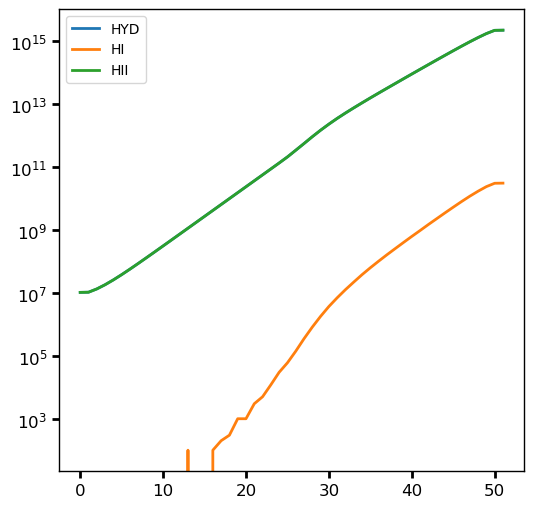

In [227]:
plt.semilogy(z['n'],z['HYD'],label='HYD')
plt.semilogy(z['n'],z['HI'],label='HI')
plt.semilogy(z['n'],z['HII'],label='HII')
plt.legend()

In [228]:
z=ascii.read('a3.CARB.txt')
z.info()

<Table length=52>
name  dtype 
---- -------
   n   int64
CARB float64
CIII float64
 CIV float64
  CV float64


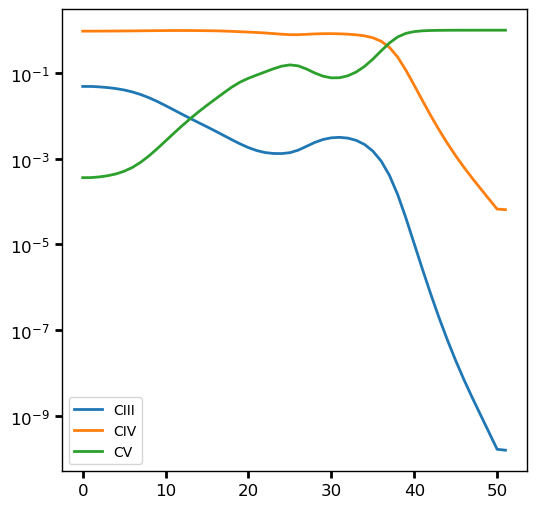

In [229]:
# plt.semilogy(z['n'],z['CII']/z['CARB'],label='CII')
plt.semilogy(z['n'],z['CIII']/z['CARB'],label='CIII')
plt.semilogy(z['n'],z['CIV']/z['CARB'],label='CIV')
plt.semilogy(z['n'],z['CV']/z['CARB'],label='CV')
plt.legend()

(1e-12, 2)

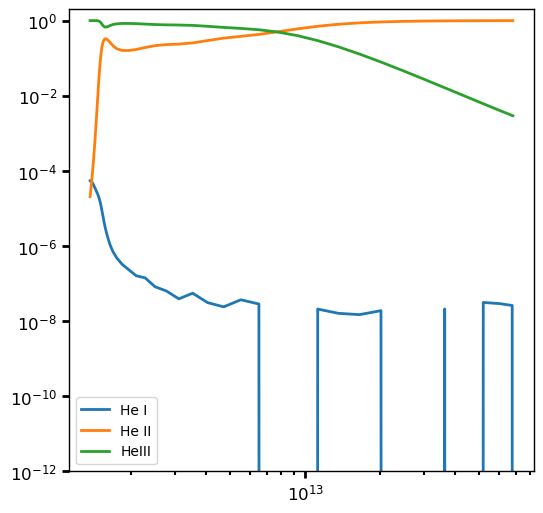

In [230]:
xmod = ascii.read("a3.rvtj.txt")
xion = ascii.read("a3.HE.txt")
xall=join(xmod,xion,join_type='left')

plt.loglog(xall['r'], xall['HeI']/xall['HE'], label="He I")
plt.loglog(xall['r'], xall['HeII']/xall['HE'], label="He II")
plt.loglog(xall['r'], xall['HeIII']/xall['HE'], label="HeIII")
plt.legend()
plt.ylim(1e-12,2)

(1e-12, 2)

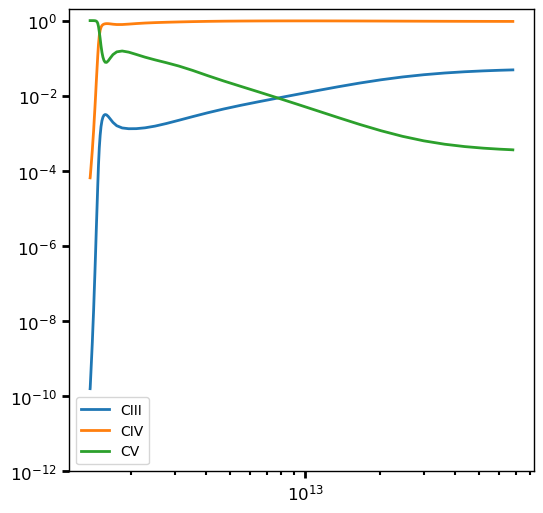

In [231]:
xmod = ascii.read("a3.rvtj.txt")
xion = ascii.read("a3.CARB.txt")
xall=join(xmod,xion,join_type='left')
# plt.loglog(xall['r'], xall['CII']/xall['CARB'], label="CII")
plt.loglog(xall['r'], xall['CIII']/xall['CARB'], label="CIII")
plt.loglog(xall['r'], xall['CIV']/xall['CARB'], label="CIV")
plt.loglog(xall['r'], xall['CV']/xall['CARB'], label="CV")
plt.legend()
plt.ylim(1e-12,2)

(1e-12, 2)

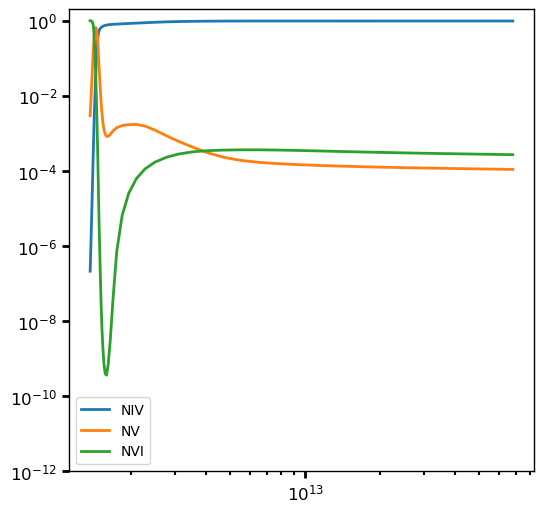

In [232]:
xmod = ascii.read("a3.rvtj.txt")
xion = ascii.read("a3.NIT.txt")
xall=join(xmod,xion,join_type='left')
# plt.loglog(xall['r'], xall['CII']/xall['CARB'], label="CII")
# plt.loglog(xall['r'], xall['NIII']/xall['NIT'], label="NIII")
plt.loglog(xall['r'], xall['NIV']/xall['NIT'], label="NIV")
plt.loglog(xall['r'], xall['NV']/xall['NIT'], label="NV")
plt.loglog(xall['r'], xall['NVI']/xall['NIT'], label="NVI")
plt.legend()
plt.ylim(1e-12,2)


(1e-12, 2)

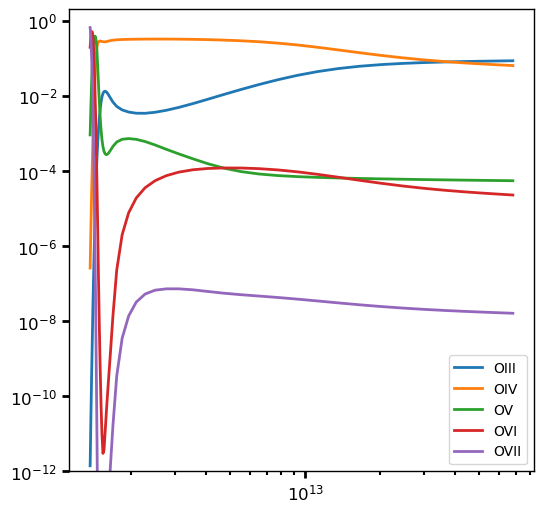

In [233]:
xmod = ascii.read("a3.rvtj.txt")
xion = ascii.read("a3.OXY.txt")
xall=join(xmod,xion,join_type='left')
# plt.loglog(xall['r'], xall['CII']/xall['CARB'], label="CII")
# plt.loglog(xall['r'], xall['NIII']/xall['NIT'], label="NIII")
plt.loglog(xall['r'], xall['OIII']/xall['OXY'], label="OIII")
plt.loglog(xall['r'], xall['OIV']/xall['OXY'], label="OIV")
plt.loglog(xall['r'], xall['OV']/xall['OXY'], label="OV")
plt.loglog(xall['r'], xall['OVI']/xall['OXY'], label="OVI")
plt.loglog(xall['r'], xall['OVII']/xall['OXY'], label="OVII")
plt.legend()
plt.ylim(1e-12,2)

Now go through and add r suste,atoca;;u

In [234]:
def add_r(xfile,rfile="a3.rvtj.txt"):
    xmod=ascii.read(rfile)
    xion=ascii.read(xfile)
    xall=join(xmod['n','r'],xion,join_type='left')
    i=1
    while i<len(xall.colnames):
        xall[xall.colnames[i]].format='12.8e'
        i+=1
    xall.write(xfile,format='ascii.fixed_width_two_line',overwrite=True)  
    return

add_r('a3.IRON.txt')

In [235]:
add_r('a3.HYD.txt')
add_r('a3.CARB.txt')
add_r('a3.OXY.txt')
add_r('a3.NIT.txt')
add_r('a3.HE.txt')

(1e-12, 2)

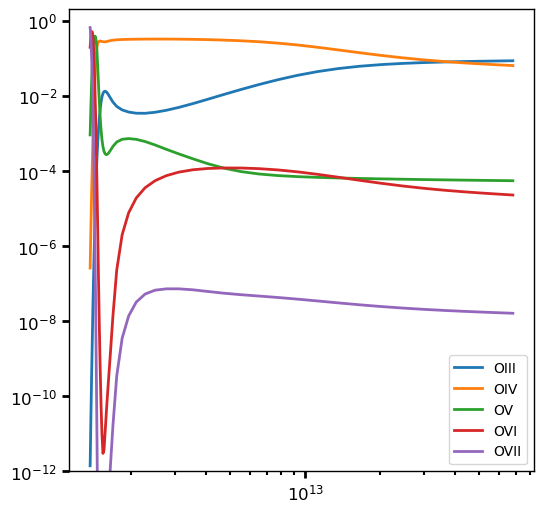

In [236]:

xall = ascii.read("a3.OXY.txt")

# plt.loglog(xall['r'], xall['CII']/xall['CARB'], label="CII")
# plt.loglog(xall['r'], xall['NIII']/xall['NIT'], label="NIII")
plt.loglog(xall['r'], xall['OIII']/xall['OXY'], label="OIII")
plt.loglog(xall['r'], xall['OIV']/xall['OXY'], label="OIV")
plt.loglog(xall['r'], xall['OV']/xall['OXY'], label="OV")
plt.loglog(xall['r'], xall['OVI']/xall['OXY'], label="OVI")
plt.loglog(xall['r'], xall['OVII']/xall['OXY'], label="OVII")
plt.legend()
plt.ylim(1e-12,2)